In [6]:
%matplotlib inline

# Q1:  Document Classification
<h2> Q1.1: Reuters Dataset Exploration </h2>
<h3> Turn the code of the Sklearn tutorial above into a notebook  </h3>


# Out-of-core classification of text documents


This is an example showing how scikit-learn can be used for classification
using an out-of-core approach: learning from data that doesn't fit into main
memory. We make use of an online classifier, i.e., one that supports the
partial_fit method, that will be fed with batches of examples. To guarantee
that the features space remains the same over time we leverage a
HashingVectorizer that will project each example into the same feature space.
This is especially useful in the case of text classification where new
features (words) may appear in each batch.

The dataset used in this example is Reuters-21578 as provided by the UCI ML
repository. It will be automatically downloaded and uncompressed on first run.

The plot represents the learning curve of the classifier: the evolution
of classification accuracy over the course of the mini-batches. Accuracy is
measured on the first 1000 samples, held out as a validation set.

To limit the memory consumption, we queue examples up to a fixed amount before
feeding them to the learner.



In [7]:
# Authors: Eustache Diemert <eustache@diemert.fr>
#          @FedericoV <https://github.com/FedericoV/>
# License: BSD 3 clause

from __future__ import print_function

from glob import glob
import itertools
import os.path
import re
import tarfile
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.externals.six.moves import html_parser
from sklearn.externals.six.moves import urllib
from sklearn.datasets import get_data_home
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB


def _not_in_sphinx():
    # Hack to detect whether we are running by the sphinx builder
    return '__file__' in globals()

Reuters Dataset related routines
--------------------------------




In [8]:
class ReutersParser(html_parser.HTMLParser):
    """Utility class to parse a SGML file and yield documents one at a time."""

    def __init__(self, encoding='latin-1'):
        html_parser.HTMLParser.__init__(self)
        self._reset()
        self.encoding = encoding

    def handle_starttag(self, tag, attrs):
        method = 'start_' + tag
        getattr(self, method, lambda x: None)(attrs)

    def handle_endtag(self, tag):
        method = 'end_' + tag
        getattr(self, method, lambda: None)()

    def _reset(self):
        self.in_title = 0
        self.in_body = 0
        self.in_topics = 0
        self.in_topic_d = 0
        self.title = ""
        self.body = ""
        self.topics = []
        self.topic_d = ""

    def parse(self, fd):
        self.docs = []
        for chunk in fd:
            self.feed(chunk.decode(self.encoding))
            for doc in self.docs:
                yield doc
            self.docs = []
        self.close()

    def handle_data(self, data):
        if self.in_body:
            self.body += data
        elif self.in_title:
            self.title += data
        elif self.in_topic_d:
            self.topic_d += data

    def start_reuters(self, attributes):
        pass

    def end_reuters(self):
        self.body = re.sub(r'\s+', r' ', self.body)
        self.docs.append({'title': self.title,
                          'body': self.body,
                          'topics': self.topics})
        self._reset()

    def start_title(self, attributes):
        self.in_title = 1

    def end_title(self):
        self.in_title = 0

    def start_body(self, attributes):
        self.in_body = 1

    def end_body(self):
        self.in_body = 0

    def start_topics(self, attributes):
        self.in_topics = 1

    def end_topics(self):
        self.in_topics = 0

    def start_d(self, attributes):
        self.in_topic_d = 1

    def end_d(self):
        self.in_topic_d = 0
        self.topics.append(self.topic_d)
        self.topic_d = ""


def stream_reuters_documents(data_path=None):
    """Iterate over documents of the Reuters dataset.

    The Reuters archive will automatically be downloaded and uncompressed if
    the `data_path` directory does not exist.

    Documents are represented as dictionaries with 'body' (str),
    'title' (str), 'topics' (list(str)) keys.

    """

    DOWNLOAD_URL = ('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                    'reuters21578-mld/reuters21578.tar.gz')
    ARCHIVE_FILENAME = 'reuters21578.tar.gz'

    if data_path is None:
        data_path = os.path.join(get_data_home(), "reuters")
    if not os.path.exists(data_path):
        """Download the dataset."""
        print("downloading dataset (once and for all) into %s" %
              data_path)
        os.mkdir(data_path)

        def progress(blocknum, bs, size):
            total_sz_mb = '%.2f MB' % (size / 1e6)
            current_sz_mb = '%.2f MB' % ((blocknum * bs) / 1e6)
            if _not_in_sphinx():
                print('\rdownloaded %s / %s' % (current_sz_mb, total_sz_mb),
                      end='')

        archive_path = os.path.join(data_path, ARCHIVE_FILENAME)
        urllib.request.urlretrieve(DOWNLOAD_URL, filename=archive_path,
                                   reporthook=progress)
        if _not_in_sphinx():
            print('\r', end='')
        print("untarring Reuters dataset...")
        tarfile.open(archive_path, 'r:gz').extractall(data_path)
        print("done.")

    parser = ReutersParser()
    for filename in glob(os.path.join(data_path, "*.sgm")):
        for doc in parser.parse(open(filename, 'rb')):
            yield doc

Main
----

Create the vectorizer and limit the number of features to a reasonable
maximum



In [9]:
vectorizer = HashingVectorizer(decode_error='ignore', n_features=2 ** 18,
                               non_negative=True)


# Iterator over parsed Reuters SGML files.
data_stream = stream_reuters_documents()

# We learn a binary classification between the "acq" class and all the others.
# "acq" was chosen as it is more or less evenly distributed in the Reuters
# files. For other datasets, one should take care of creating a test set with
# a realistic portion of positive instances.
all_classes = np.array([0, 1])
positive_class = 'acq'

# Here are some classifiers that support the `partial_fit` method
partial_fit_classifiers = {
    'SGD': SGDClassifier(),
    'Perceptron': Perceptron(),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(),
}


def get_minibatch(doc_iter, size, pos_class=positive_class):
    """Extract a minibatch of examples, return a tuple X_text, y.

    Note: size is before excluding invalid docs with no topics assigned.

    """
    data = [(u'{title}\n\n{body}'.format(**doc), pos_class in doc['topics'])
            for doc in itertools.islice(doc_iter, size)
            if doc['topics']]
    if not len(data):
        return np.asarray([], dtype=int), np.asarray([], dtype=int)
    X_text, y = zip(*data)
    return X_text, np.asarray(y, dtype=int)


def iter_minibatches(doc_iter, minibatch_size):
    """Generator of minibatches."""
    X_text, y = get_minibatch(doc_iter, minibatch_size)
    while len(X_text):
        yield X_text, y
        X_text, y = get_minibatch(doc_iter, minibatch_size)


# test data statistics
test_stats = {'n_test': 0, 'n_test_pos': 0}

# First we hold out a number of examples to estimate accuracy
n_test_documents = 1000
tick = time.time()
X_test_text, y_test = get_minibatch(data_stream, 1000)
parsing_time = time.time() - tick
tick = time.time()
X_test = vectorizer.transform(X_test_text)
vectorizing_time = time.time() - tick
test_stats['n_test'] += len(y_test)
test_stats['n_test_pos'] += sum(y_test)
print("Test set is %d documents (%d positive)" % (len(y_test), sum(y_test)))


def progress(cls_name, stats):
    """Report progress information, return a string."""
    duration = time.time() - stats['t0']
    s = "%20s classifier : \t" % cls_name
    s += "%(n_train)6d train docs (%(n_train_pos)6d positive) " % stats
    s += "%(n_test)6d test docs (%(n_test_pos)6d positive) " % test_stats
    s += "accuracy: %(accuracy).3f " % stats
    s += "in %.2fs (%5d docs/s)" % (duration, stats['n_train'] / duration)
    return s


cls_stats = {}

for cls_name in partial_fit_classifiers:
    stats = {'n_train': 0, 'n_train_pos': 0,
             'accuracy': 0.0, 'accuracy_history': [(0, 0)], 't0': time.time(),
             'runtime_history': [(0, 0)], 'total_fit_time': 0.0}
    cls_stats[cls_name] = stats

get_minibatch(data_stream, n_test_documents)
# Discard test set

# We will feed the classifier with mini-batches of 1000 documents; this means
# we have at most 1000 docs in memory at any time.  The smaller the document
# batch, the bigger the relative overhead of the partial fit methods.
minibatch_size = 1000

# Create the data_stream that parses Reuters SGML files and iterates on
# documents as a stream.
minibatch_iterators = iter_minibatches(data_stream, minibatch_size)
total_vect_time = 0.0

# Main loop : iterate on mini-batches of examples
for i, (X_train_text, y_train) in enumerate(minibatch_iterators):

    tick = time.time()
    X_train = vectorizer.transform(X_train_text)
    total_vect_time += time.time() - tick

    for cls_name, cls in partial_fit_classifiers.items():
        tick = time.time()
        # update estimator with examples in the current mini-batch
        cls.partial_fit(X_train, y_train, classes=all_classes)

        # accumulate test accuracy stats
        cls_stats[cls_name]['total_fit_time'] += time.time() - tick
        cls_stats[cls_name]['n_train'] += X_train.shape[0]
        cls_stats[cls_name]['n_train_pos'] += sum(y_train)
        tick = time.time()
        cls_stats[cls_name]['accuracy'] = cls.score(X_test, y_test)
        cls_stats[cls_name]['prediction_time'] = time.time() - tick
        acc_history = (cls_stats[cls_name]['accuracy'],
                       cls_stats[cls_name]['n_train'])
        cls_stats[cls_name]['accuracy_history'].append(acc_history)
        run_history = (cls_stats[cls_name]['accuracy'],
                       total_vect_time + cls_stats[cls_name]['total_fit_time'])
        cls_stats[cls_name]['runtime_history'].append(run_history)

        if i % 3 == 0:
            print(progress(cls_name, cls_stats[cls_name]))
    if i % 3 == 0:
        print('\n')

Test set is 878 documents (108 positive)
  Passive-Aggressive classifier : 	   962 train docs (   132 positive)    878 test docs (   108 positive) accuracy: 0.894 in 1.16s (  830 docs/s)
          Perceptron classifier : 	   962 train docs (   132 positive)    878 test docs (   108 positive) accuracy: 0.921 in 1.16s (  827 docs/s)
                 SGD classifier : 	   962 train docs (   132 positive)    878 test docs (   108 positive) accuracy: 0.931 in 1.16s (  825 docs/s)
      NB Multinomial classifier : 	   962 train docs (   132 positive)    878 test docs (   108 positive) accuracy: 0.877 in 1.18s (  813 docs/s)


  Passive-Aggressive classifier : 	  3911 train docs (   517 positive)    878 test docs (   108 positive) accuracy: 0.937 in 3.96s (  988 docs/s)
          Perceptron classifier : 	  3911 train docs (   517 positive)    878 test docs (   108 positive) accuracy: 0.926 in 3.96s (  987 docs/s)
                 SGD classifier : 	  3911 train docs (   517 positive)    878 tes

Plot results
------------



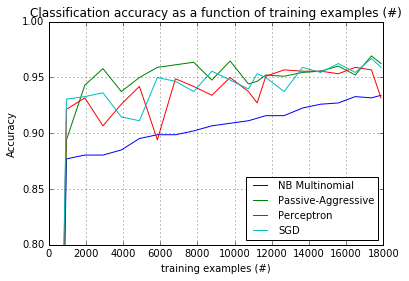

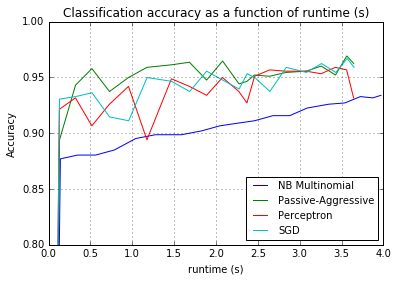

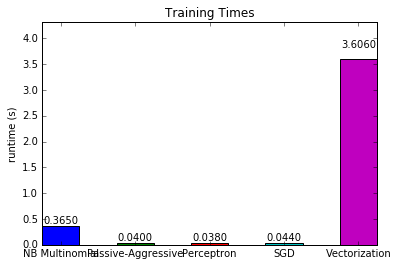

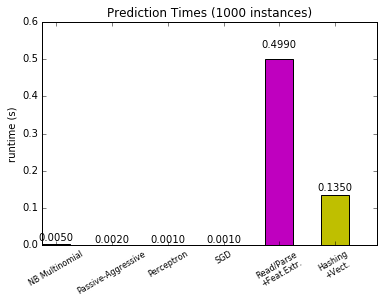

In [10]:
def plot_accuracy(x, y, x_legend):
    """Plot accuracy as a function of x."""
    x = np.array(x)
    y = np.array(y)
    plt.title('Classification accuracy as a function of %s' % x_legend)
    plt.xlabel('%s' % x_legend)
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.plot(x, y)

rcParams['legend.fontsize'] = 10
cls_names = list(sorted(cls_stats.keys()))

# Plot accuracy evolution
plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with #examples
    accuracy, n_examples = zip(*stats['accuracy_history'])
    plot_accuracy(n_examples, accuracy, "training examples (#)")
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc='best')

plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with runtime
    accuracy, runtime = zip(*stats['runtime_history'])
    plot_accuracy(runtime, accuracy, 'runtime (s)')
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc='best')

# Plot fitting times
plt.figure()
fig = plt.gcf()
cls_runtime = []
for cls_name, stats in sorted(cls_stats.items()):
    cls_runtime.append(stats['total_fit_time'])

cls_runtime.append(total_vect_time)
cls_names.append('Vectorization')
bar_colors = ['b', 'g', 'r', 'c', 'm', 'y']

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5,
                     color=bar_colors)

ax.set_xticks(np.linspace(0.25, len(cls_names) - 0.75, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=10)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel('runtime (s)')
ax.set_title('Training Times')


def autolabel(rectangles):
    """attach some text vi autolabel on rectangles."""
    for rect in rectangles:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2.,
                1.05 * height, '%.4f' % height,
                ha='center', va='bottom')

autolabel(rectangles)
plt.show()

# Plot prediction times
plt.figure()
cls_runtime = []
cls_names = list(sorted(cls_stats.keys()))
for cls_name, stats in sorted(cls_stats.items()):
    cls_runtime.append(stats['prediction_time'])
cls_runtime.append(parsing_time)
cls_names.append('Read/Parse\n+Feat.Extr.')
cls_runtime.append(vectorizing_time)
cls_names.append('Hashing\n+Vect.')

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5,
                     color=bar_colors)

ax.set_xticks(np.linspace(0.25, len(cls_names) - 0.75, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=8)
plt.setp(plt.xticks()[1], rotation=30)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel('runtime (s)')
ax.set_title('Prediction Times (%d instances)' % n_test_documents)
autolabel(rectangles)
plt.show()

<h3> Explore how many documents are in the dataset, how many categories, how many documents per categories</h3> 

In [29]:
# Reuters-21578 dataset downloader and parser
#
# Author:  Eustache Diemert <eustache@diemert.fr> 
# http://scikit-learn.org/stable/auto_examples/applications/plot_out_of_core_classification.html
#
# Modified by @herrfz, get pandas DataFrame from the orig SGML
# License: BSD 3 clause

from __future__ import print_function

import re
import os.path
import fnmatch
import sgmllib
import urllib
import tarfile
import itertools
from pandas import DataFrame

###############################################################################
# Reuters Dataset related routines
###############################################################################


def _not_in_sphinx():
    # Hack to detect whether we are running by the sphinx builder
    return '__file__' in globals()


class ReutersParser(sgmllib.SGMLParser):
    """Utility class to parse a SGML file and yield documents one at a time."""
    def __init__(self, verbose=0):
        sgmllib.SGMLParser.__init__(self, verbose)
        self._reset()

    def _reset(self):
        self.in_title = 0
        self.in_body = 0
        self.in_topics = 0
        self.in_topic_d = 0
        self.title = ""
        self.body = ""
        self.topics = []
        self.topic_d = ""

    def parse(self, fd):
        self.docs = []
        for chunk in fd:
            self.feed(chunk)
            for doc in self.docs:
                yield doc
            self.docs = []
        self.close()

    def handle_data(self, data):
        if self.in_body:
            self.body += data
        elif self.in_title:
            self.title += data
        elif self.in_topic_d:
            self.topic_d += data

    def start_reuters(self, attributes):
        pass

    def end_reuters(self):
        self.body = re.sub(r'\s+', r' ', self.body)
        self.docs.append({'title': self.title,
                          'body': self.body,
                          'topics': self.topics})
        self._reset()

    def start_title(self, attributes):
        self.in_title = 1

    def end_title(self):
        self.in_title = 0

    def start_body(self, attributes):
        self.in_body = 1

    def end_body(self):
        self.in_body = 0

    def start_topics(self, attributes):
        self.in_topics = 1

    def end_topics(self):
        self.in_topics = 0

    def start_d(self, attributes):
        self.in_topic_d = 1

    def end_d(self):
        self.in_topic_d = 0
        self.topics.append(self.topic_d)
        self.topic_d = ""


class ReutersStreamReader():

    """Iterate over documents of the Reuters dataset.
    The Reuters archive will automatically be downloaded and uncompressed if
    the `data_path` directory does not exist.
    Documents are represented as dictionaries with 'body' (str),
    'title' (str), 'topics' (list(str)) keys.
    """

    DOWNLOAD_URL = ('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                    'reuters21578-mld/reuters21578.tar.gz')
    ARCHIVE_FILENAME = 'reuters21578.tar.gz'

    def __init__(self, data_path):
        self.data_path = data_path
        if not os.path.exists(self.data_path):
            self.download_dataset()

    def download_dataset(self):
        """Download the dataset."""
        print("downloading dataset (once and for all) into %s" %
              self.data_path)
        os.mkdir(self.data_path)

        def progress(blocknum, bs, size):
            total_sz_mb = '%.2f MB' % (size / 1e6)
            current_sz_mb = '%.2f MB' % ((blocknum * bs) / 1e6)
            if _not_in_sphinx():
                print('\rdownloaded %s / %s' % (current_sz_mb, total_sz_mb),
                      end='')
        urllib.urlretrieve(self.DOWNLOAD_URL,
                           filename=os.path.join(self.data_path,
                                                 self.ARCHIVE_FILENAME),
                           reporthook=progress)
        if _not_in_sphinx():
            print('\r', end='')
        print("untaring data ...")
        tfile = tarfile.open(os.path.join(self.data_path,
                                          self.ARCHIVE_FILENAME),
                             'r:gz')
        tfile.extractall(self.data_path)
        print("done !")

    def iterdocs(self):
        """Iterate doc by doc, yield a dict."""
        for root, _dirnames, filenames in os.walk(self.data_path):
            for filename in fnmatch.filter(filenames, '*.sgm'):
                path = os.path.join(root, filename)
                parser = ReutersParser()
                for doc in parser.parse(open(path)):
                    yield doc


def get_minibatch(doc_iter, size):
    """Extract a minibatch of examples, return a tuple X, y.
    Note: size is before excluding invalid docs with no topics assigned.
    """
    data = [('{title}\n\n{body}'.format(**doc), doc['topics'])
            for doc in itertools.islice(doc_iter, size)
            if doc['topics']]
    if not len(data):
	return DataFrame([])
    else:
        return DataFrame(data, columns=['text', 'tags'])


In [78]:
import pandas as pd
import numpy as np

#data_streamer = ReutersStreamReader('reuters').iterdocs()
#y = len(list(data_streamer))
#print(y)

data_streamer = ReutersStreamReader('reuters').iterdocs()
data = get_minibatch(data_streamer, None)
print("number of labeled documents in dataset ",data.count())

#type(data)


number of labeled documents in dataset  text    19716
tags    19716
dtype: int64


In [79]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit_transform(data['tags'])
print("number of categories in dataset ",len(mlb.classes_))

#data[0:10]
#print(mlb.classes_)

number of categories in dataset  445


In [22]:
# -*- coding: utf-8 -*-
from __future__ import absolute_import
from six.moves import cPickle
from six.moves import zip
import numpy as np
import sys
from keras.utils.data_utils import get_file


def load_data(path='reuters.pkl', nb_words=None, skip_top=0,
              maxlen=None, test_split=0.2, seed=113,
              start_char=1, oov_char=2, index_from=3):
    '''Loads the Reuters newswire classification dataset.

    # Arguments
        path: where to store the data (in `/.keras/dataset`)
        nb_words: max number of words to include. Words are ranked
            by how often they occur (in the training set) and only
            the most frequent words are kept
        skip_top: skip the top N most frequently occuring words
            (which may not be informative).
        maxlen: truncate sequences after this length.
        test_split: Fraction of the dataset to be used as test data.
        seed: random seed for sample shuffling.
        start_char: The start of a sequence will be marked with this character.
            Set to 1 because 0 is usually the padding character.
        oov_char: words that were cut out because of the `nb_words`
            or `skip_top` limit will be replaced with this character.
        index_from: index actual words with this index and higher.

    Note that the 'out of vocabulary' character is only used for
    words that were present in the training set but are not included
    because they're not making the `nb_words` cut here.
    Words that were not seen in the trining set but are in the test set
    have simply been skipped.
    '''

    path = get_file(path, origin='https://s3.amazonaws.com/text-datasets/reuters.pkl')
    f = open(path, 'rb')
    X, labels = cPickle.load(f)
    f.close()

    np.random.seed(seed)
    np.random.shuffle(X)
    np.random.seed(seed)
    np.random.shuffle(labels)

    if start_char is not None:
        X = [[start_char] + [w + index_from for w in x] for x in X]
    elif index_from:
        X = [[w + index_from for w in x] for x in X]

    if maxlen:
        new_X = []
        new_labels = []
        for x, y in zip(X, labels):
            if len(x) < maxlen:
                new_X.append(x)
                new_labels.append(y)
        X = new_X
        labels = new_labels

    if not nb_words:
        nb_words = max([max(x) for x in X])

    # by convention, use 2 as OOV word
    # reserve 'index_from' (=3 by default) characters: 0 (padding), 1 (start), 2 (OOV)
    if oov_char is not None:
        X = [[oov_char if (w >= nb_words or w < skip_top) else w for w in x] for x in X]
    else:
        nX = []
        for x in X:
            nx = []
            for w in x:
                if (w >= nb_words or w < skip_top):
                    nx.append(w)
            nX.append(nx)
        X = nX

    X_train = X[:int(len(X) * (1 - test_split))]
    y_train = labels[:int(len(X) * (1 - test_split))]

    X_test = X[int(len(X) * (1 - test_split)):]
    y_test = labels[int(len(X) * (1 - test_split)):]

    return (X_train, y_train), (X_test, y_test)

In [ ]:
def explore_reuters_documents(data_path=None):
    """Iterate over documents of the Reuters dataset.

    The Reuters archive will automatically be downloaded and uncompressed if
    the `data_path` directory does not exist.

    Documents are represented as dictionaries with 'body' (str),
    'title' (str), 'topics' (list(str)) keys.

    """

    DOWNLOAD_URL = ('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                    'reuters21578-mld/reuters21578.tar.gz')
    ARCHIVE_FILENAME = 'reuters21578.tar.gz'

    if data_path is None:
        data_path = os.path.join(get_data_home(), "reuters")
    if not os.path.exists(data_path):
        """Download the dataset."""
        print("downloading dataset (once and for all) into %s" %
              data_path)
        os.mkdir(data_path)

        def progress(blocknum, bs, size):
            total_sz_mb = '%.2f MB' % (size / 1e6)
            current_sz_mb = '%.2f MB' % ((blocknum * bs) / 1e6)
            if _not_in_sphinx():
                print('\rdownloaded %s / %s' % (current_sz_mb, total_sz_mb),
                      end='')

        archive_path = os.path.join(data_path, ARCHIVE_FILENAME)
        urllib.request.urlretrieve(DOWNLOAD_URL, filename=archive_path,
                                   reporthook=progress)
        if _not_in_sphinx():
            print('\r', end='')
        print("untarring Reuters dataset...")
        tarfile.open(archive_path, 'r:gz').extractall(data_path)
        print("done.")

    parser = ReutersParser()
    for filename in glob(os.path.join(data_path, "*.sgm")):
        for doc in parser.parse(open(filename, 'rb')):
            yield doc